In [115]:
import pandas as pd

df = pd.read_csv("harjoitustyondata.csv", sep=";")
# Turning time into a datetime object
df['Aika'] = pd.to_datetime(df['Aika'], format='%d.%m.%Y %H:%M')
# print(df)

# Getting information about students
students = df.Pisteet.unique()
print(len(students), min(students), max(students))
course_start = df['Aika'].min()
course_end = df['Aika'].max()
print(course_start, course_end)

# To make things easier, let's collect the students into a dictionary, 
# where the points are the key to a list of all the timestamps
student_dict = {}
for student in students:
    # This gives us a dataframe 
    student_info = df.loc[df['Pisteet'] == student]
    timestamp_list = student_info['Aika'].tolist()
    student_dict[student] = timestamp_list
 

# print((max(student_dict[1055]) - min(student_dict[1055])).total_seconds())

    

150 1055 7594
2019-08-07 10:15:00 2020-01-29 14:11:00


Above we are sorting the data. The data is first turned into a Pandas DataFrame.
In the dataset, we have 150 different students, whose score range from 1055 points to 7594 points.
The first entry was 7.8.2019 and the last 29.1.2020, so we are assuming this is the duration of the course. 
This would mean that the course was active for about 6 months. 

We should probably analyze the data a bit more to get more information about the course and how to build the model.
Let's see how long each students took to complete (or give up on) the course.
    - plotting on the x-axis the amount of time used (in days)
    - the course points are in the y-axis

(To make this easier, the student data was turned into a dictionary, where student points are the keys, with 
the timestamps in a list as value.)

Below we can see that the point distribution is a bit unusual. Most of the students collected very high points.



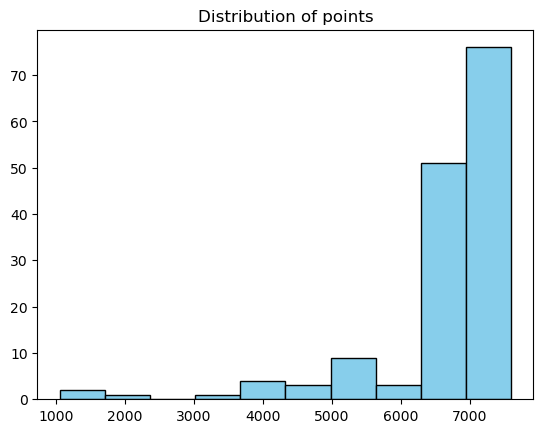

In [118]:
plt.hist(students, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of points')
plt.show()

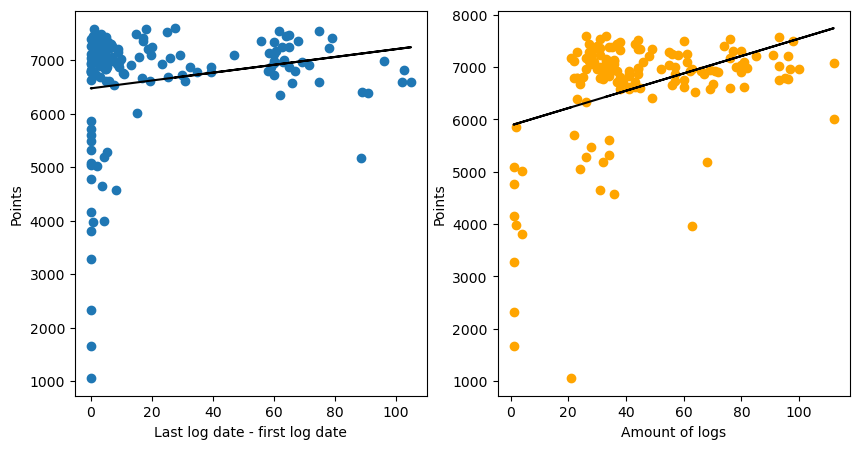

In [193]:
import matplotlib.pyplot as plt
import numpy as np

# The time each student took to complete the course
times = [(max(student_dict[s]) - min(student_dict[s])).total_seconds() / (60*60*24) for s in students]
# The number of different timestamps, i.e. the number of logs in total done by the student
logs = [len(student_dict[s]) for s in students]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

times = np.array(times)
logs = np.array(logs)
students = np.array(students)

# regression models
time_slope, time_intercept = np.polyfit(times, students, 1)
logs_slope, logs_intercept = np.polyfit(logs, students, 1)

ax1.plot(times, students, 'o')
ax1.set_xlabel('Last log date - first log date')
ax1.set_ylabel('Points')

ax2.plot(logs, students, 'o', color="orange")
ax2.set_xlabel('Amount of logs')
ax2.set_ylabel('Points')

ax1.plot(times, time_slope * times + time_intercept, color='black')
ax2.plot(logs, logs_slope * logs + logs_intercept, color='black')

plt.show()

Above on the left we can see that most of the students got very high points, a lot of them in a relatively short time interval.
On the right, we can see that the amount of logs can vary a lot for the grade. 

Based on this, it would not seem like a good idea to classify the students actions based on the amount of logs or days spent working on the course alone. _I would have expected more of a straightforward linear dependece on both -> the more hours spent on the course, the better grade etc_ 

_Let's see if there is a connection between the points and the amount of different days spent on the project_



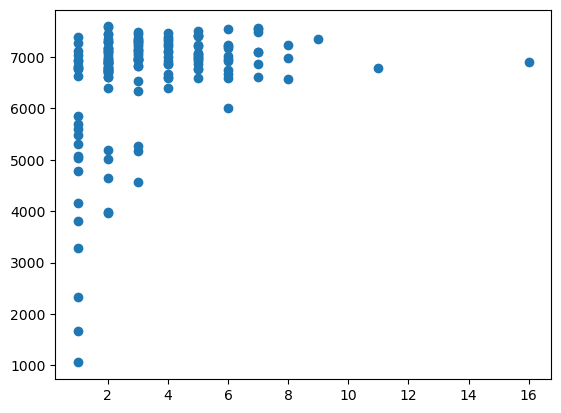

In [104]:
# Finding out on how many different days a student worked on the course
dates = []
for s in students:
    # Taking just the dates from timestamps, 
    # turning them into strings and to get only the unique values, turn the list into set
    t = set([ str(d.date()) for d in student_dict[s]])
    # Append it as a list, 
    dates.append(len(t)) 

plt.plot(dates, students, 'o')
plt.show()

Above can be seen that almost all of the students completed the course with less than 10 days activity logged.


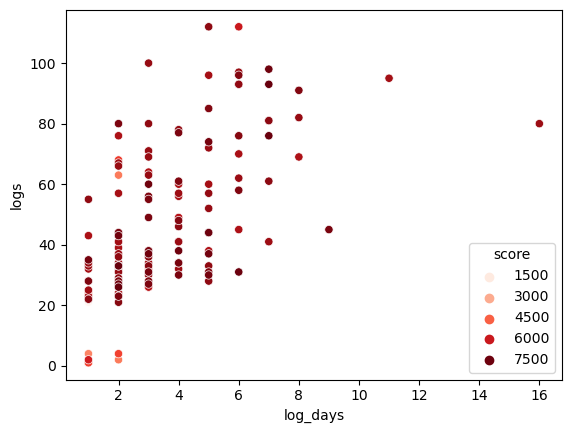

In [183]:
import seaborn as sns

# Here's a new dataframe for seaborn plotting.
# logs means the amount of logs,
# comp_t means the difference between last and first log, i.e. the course completion time
# log_days is the amount of days that logging has been done
data = {"score": students, "logs": logs, "comp_t": times, "log_days":dates }
df = pd.DataFrame(data)

sns.scatterplot(x="log_days",
                    y="logs",
                    hue="score",
                    data=df, palette='Reds')
plt.show()

Above we can kinda see a trend: multiple logs over multiple days seems to give a good grade. There is still quite a bit of clustering downish and left, I don't really know what to make of that :/